# UMAP visualization of high-dimensional transformer output

Having used classifier.py to fine tune a pre-trained model, this notebook allows for visualization of the transormer output. (I.E. the notebook visualizes the vectorspace that the model uses to classify the data.)

We use the extract_features.py script to load the model and write to json of the with fields for id, proper label, predicted label, values (the vector), text, and confidence (the range of logits).

In [1]:
import json 
with open("./output/features.json") as f:
    vec_features = [json.loads(line) for line in f]

We want to visualize these data using plotly so we seperate the list of dictionaries into lists of vectors, labels, ids, sizes, and booleans (representing whether the model correctly predicted the label).

In [3]:
import numpy as np
from math import sqrt
np.random.seed(42)
vectors = np.array([feature["vector"] for feature in vec_features])
labels = [feature["label"] for feature in vec_features]
ids = [feature["id"] for feature in vec_features]
sizes = [feature["confidence"] for feature in vec_features]
correct = [feature["label"]==feature["prediction"] for feature in vec_features]

To visualize the high dimensional vectorspace, we use a process called Uniform Manifold Approximation and Projection (UMAP) to reduce the vectors to two dimensions. 

In [5]:
import umap
reducer = umap.UMAP(n_neighbors=70, min_dist=.01)
%time embedding = reducer.fit_transform(vectors)

CPU times: user 1min 6s, sys: 2.35 s, total: 1min 9s
Wall time: 1min 9s


We break up the data into left, right, and left_incorrect groups so we can plot them as different categories. (distinguishing incorrectly labeled left cases because they are likely to be surrounded by right cases. As right cases are drawn second, this would obscure the nearby left cases unless they are seperatly drawn afterwards.) 

In [6]:
bundled_data = zip(embedding, labels, ids, sizes, correct)
left = []
right = []
left_incorrect = [] # seperate so they can be drawn over other data (for visibility)
for case in bundled_data:
    if case[1] == 0: # if label is 0, case is left leaning
        if case[4]:
            left.append(case)
        else:
            left_incorrect.append(case)
    else:
        right.append(case)

We prepare the plot to draw the left, right, and incorrect left cases:

In [8]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [9]:
embedding, labels, ids, sizes, _ = zip(*left)
embedding = np.array(embedding)
left_leaning = go.Scattergl(
    x = embedding[:,0],
    y = embedding[:,1],
    text=ids,
    hoverinfo="text",
    mode = "markers",
    name="Left Leaning",
    legendgroup="Left Leaning",
    marker = go.scattergl.Marker(
        color="blue",
        size=sizes,  
        opacity=.9,
        sizemin=3,
    )
    
)

In [10]:
embedding, labels, ids, sizes, _ = zip(*right)
embedding = np.array(embedding)
right_leaning = go.Scattergl(
    x = embedding[:,0],
    y = embedding[:,1],
    text=ids,
    hoverinfo="text",
    mode = "markers",
    name="Right Leaning",
    legendgroup="Right Leaning",
    marker = go.scattergl.Marker(
        color="red",
        size=sizes,  
        opacity=.9,
        sizemin=3,
    )
    
)


In [12]:
embedding, labels, ids, sizes, _ = zip(*left_incorrect)
embedding = np.array(embedding)
left_leaning_incorrect = go.Scattergl(
    x = embedding[:,0],
    y = embedding[:,1],
    text=ids,
    hoverinfo="text",
    mode = "markers",
    showlegend=False,
    legendgroup="Left Leaning",
    marker = go.scattergl.Marker(
        color="blue",
        size=sizes,  
        opacity=.9,
        sizemin=3,
    )
    
)

In [18]:
fig = go.FigureWidget(
    data=[left_leaning, right_leaning, left_leaning_incorrect],
    layout=go.Layout(
        hovermode="closest",
        showlegend=True,
        title="Case Similarity by Transformer Output",
        height=600,
        xaxis=go.layout.XAxis(
            showgrid=False,
            zeroline=False,
        ),
        yaxis=go.layout.YAxis(
            showgrid=False,
            zeroline=False,
        )
    )
)

### Finally, we plot the relation between the two groups:

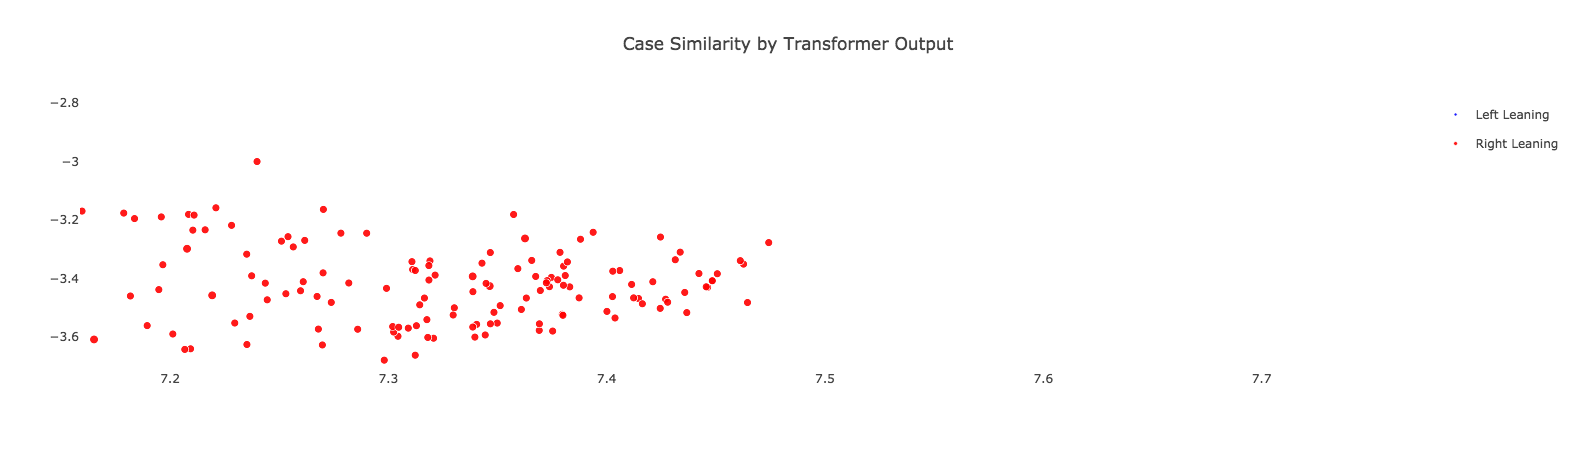

In [19]:
# iplot(fig)

Each dot represents a text document. The color of the dot represents the political leaning as indicated by its label (Blue=Left, Red=Right). The size of the dot is determined by the magnitude of the difference of the logits produced when the model attempts to classify the text as right or left leaning. (note: for a left leaning text, the right logit should ideally be very low and the left logit should be very high, leading to a very large difference. When the model has a harder time classifying the text, the logits are closer together leading to a smaller difference). Each dot is most similar to the dots closest to it and less similar to ones as they get farther away. The absolute positions along X and Y axis are meaningless. The positional information that has significance is the relative position of one dot to another. Hovering over a dot displays the unique id for that case

**Observations**
* Clear Left and Right ends
* Smoothe transition from left to right leanings. 
* The little detached island around (-5, -3) all seem to be talking to and about Students who survived the school shooting in Florida

It is interesting to compare this plot with the layout of media sources themselves. (The spread of similarity in media sources is graphed and analyzed [here](https://cyber.harvard.edu/~jclark/mediacloud/partisanship_from_twitter_followers/Twitter_Audience_Ideology_Analysis.html#Analysis)). 

We now map the case ids to the features so we can peek at data and see if that allows us to explain anything

In [21]:
id_to_text = {feature["id"]:feature for feature in vec_features}

In [9]:
id_to_text[715823467]["text"] # right dot in left clump around (-4, -1)

"Roger Stone’s Twitter Suspended After Friday Night Meltdown. President Donald Trump’s longtime adviser, Roger Stone, had his Twitter account suspended Saturday, following a tirade the night before when news broke that Special Prosecutor Robert Mueller will be filing the first charges of his five-month-long investigation into Russian collusion by the Trump campaign. “I have been informed that I have been suspended for 3 hours and 12 minutes,” Stone said in a statement. “While I am uncertain why, sometimes the stark truth offends some people. No surprising — it took me 2 years to get verified.” A Twitter spokesperson tells TheWrap that although they cannot comment on individual accounts, their police on “abusive behavior” includes “behavior that harasses.” When looking for Stone’s Twitter profile, users are directed to the “ Account Suspended ” page as of Saturday afternoon. Roger Stone's Twitter account has apparently been suspended. pic.twitter.com/wGAg1syz7n Stone launched a NSFW att

In [306]:
id_to_text[799333019]["text"] # little (-5, -3) island

'Student survivors of Florida school shooting call out NRA and legislators pushing more guns in schools.ANDERSON COOPER (HOST): There are some legislators who say that the answer is more guns. More guns in schools. People being able to, teachers, even students perhaps being able to bring in weapons. ALEXIS MICHAEL: I don\'t think bringing in more weapons would solve anything. I think that\'s just creating more violence. I just think we need to take it away from people in order to actually make a difference. [...]. EMMA GONZALEZ: The government needs to understand and people in the government need to understand that we are not to be bought by the NRA. They’re not supposed to be listening to the NRA about our protection. They’re supposed to be listening to the people getting hurt about our protection and we’re the ones who deserve to be kept safe because we were literally shot at.. Tucker Carlson: Australian-style gun safety legislation in America is "a recipe for bloodshed and civil war

In [307]:
id_to_text[804259295]["text"] # little (-5, -3) island

'Florida school shooting survivor responds to right-wing conspiracy theories: "No one\'s paying me to do this".JOHN BERMAN (HOST): Rachel, what do you say to those people, those conspiracy theorists, out there who say that you\'re an actor or say that you\'re being put up to this by liberal lawmakers? Is anyone forcing you to come on TV and talk right now?. RACHEL CATANIA (SCHOOL SHOOTING SURVIVOR): No, not at all. I\'m not getting paid for this. I want to come out here on behalf of my city and my town and just spread the message on behalf of those who can\'t. And I\'m going to make sure that those 17 innocent people who had their lives taken from them did not die for no reason. No one\'s paying me to do this. I\'m not even sure those are real. No, they\'re not real.. Tucker Carlson complains about the "moral blackmail" of student survivors speaking out about gun violence.'

#### We now pull out the left features to see if structuring them on their own allows us to pull out any more structure

In [232]:
left_features = [feature for feature in vec_features if feature["label"]==0]
data = np.array([feature.get("vector") for feature in left_features])
labels = [feature["label"] for feature in left_features]
ids = [feature["id"] for feature in left_features]
sizes = [feature["confidence"]*sqrt(feature["confidence"])+1 for feature in left_features]
correct = [feature["label"]==feature["prediction"] for feature in left_features]

In [259]:
reducer = umap.UMAP(n_neighbors=30, n_epochs=600, min_dist=.01)
%time embedding = reducer.fit_transform(data)

CPU times: user 26.7 s, sys: 1.05 s, total: 27.7 s
Wall time: 27.8 s


In [260]:
trace = go.Scattergl(
    x = embedding[:,0],
    y = embedding[:,1],
    text=ids,
    hoverinfo="text",
    mode = "markers",
    name="Left Leaning",
    legendgroup="Left Leaning",
    marker = go.scattergl.Marker(
        color="blue",
        size=sizes,  
        opacity=.9,
        sizemin=3,
    )
    
)

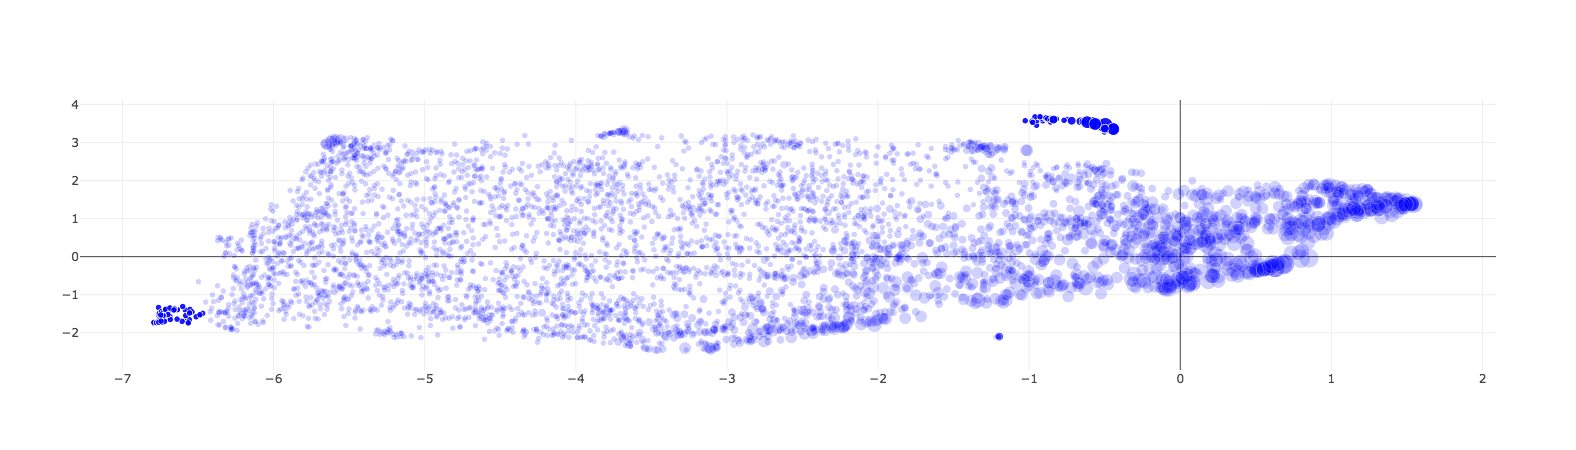

In [261]:
iplot([trace], filename="Left Structure")

In [ ]:
[934317079, 942413304, 827392042, 772465540, 929790655, 619350262] # (-1, 4) Cluster --> Seemingly by discussion of Fox News 

In [ ]:
[911432021, 889226176, 840423935, 801841793, 1034986822, 1058653007, 1058570359] # (-7, -2) Cluster of low confidence cases --> All very short (e.g. 'It didn’t work...')

#### Now we do the same for the right

In [30]:
right_features = [feature for feature in vec_features if feature["label"]==1]
data = np.array([feature.get("vector") for feature in right_features])
labels = [feature["label"] for feature in right_features]
ids = [feature["id"] for feature in right_features]
sizes = [feature["confidence"]*sqrt(feature["confidence"])+1 for feature in right_features]
correct = [feature["label"]==feature["prediction"] for feature in right_features]

In [31]:
reducer = umap.UMAP(n_neighbors=30, n_epochs=600, min_dist=.01)
%time embedding = reducer.fit_transform(data)

CPU times: user 26 s, sys: 1.05 s, total: 27.1 s
Wall time: 27.1 s


In [34]:
trace = go.Scattergl(
    x = embedding[:,0],
    y = embedding[:,1],
    text=ids,
    hoverinfo="text",
    mode = "markers",
    name="Right Leaning",
    legendgroup="Left Leaning",
    marker = go.scattergl.Marker(
        color="red",
        size=sizes,  
        opacity=.9,
        sizemin=3,
    )
    
)

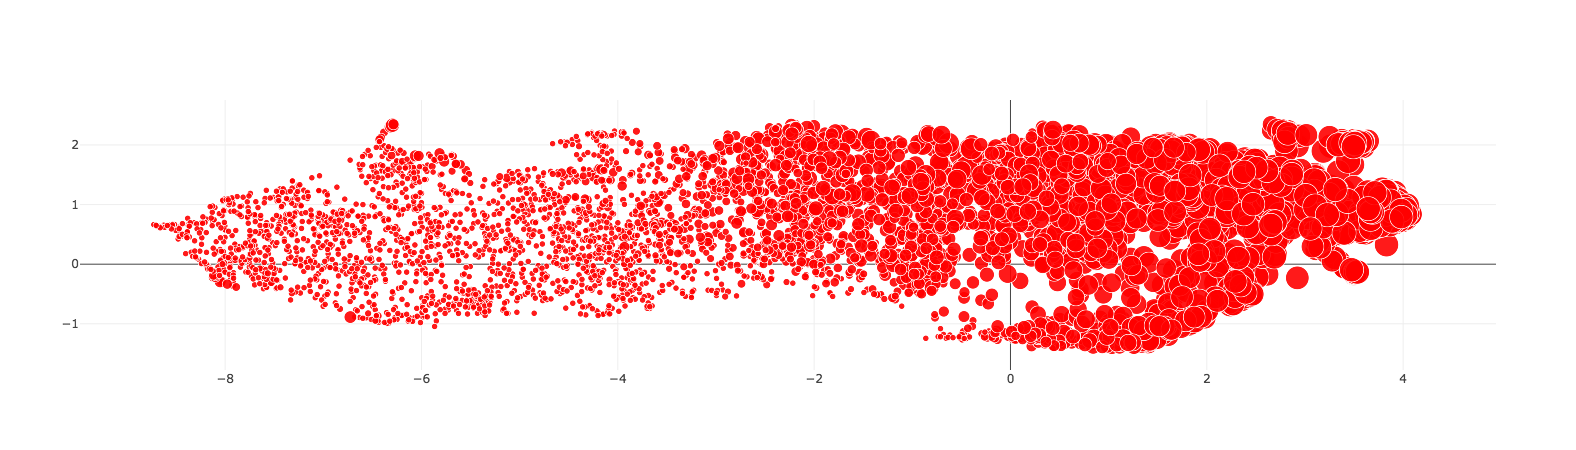

In [35]:
iplot([trace], filename="Left Structure")